In [ ]:
import kagglehub

path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

100%|██████████| 778M/778M [00:10<00:00, 75.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

!unzip -q covid19-radiography-database.zip -d covid_data




Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors


In this section, the essential libraries and modules required for image processing, data preprocessing, deep learning, and result analysis are

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import random
from torch.nn import CrossEntropyLoss
from tqdm import trange
from torchvision import models
from torch import nn
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



This function reads image filenames from an Excel file, loads the corresponding .png images, resizes them to 244×244, normalizes the pixel values, and returns them as a NumPy array for model training.

In [ ]:
def image_to_array(address_excel,image_size,address_img):
  df=pd.read_excel(address_excel)
  img_size=(244,244)
  images=[]
  for i in range(150):
    filename=df.iloc[i,0]
    if 'Normal' in address_excel:
     filename=filename[:1]+filename[1:6].lower()+filename[6:]

    try:
      img=Image.open(address_img+filename+'.png')
      img=img.resize(img_size)
      img_array=np.array(img)/255.0
      images.append(img_array)
      images_array=np.array(images)
    except:
      pass
  return (images_array)

This section loads and processes images from four different classes — Normal, Viral Pneumonia, Lung Opacity, and COVID-19 — by reading their filenames from respective metadata Excel files and converting the images into normalized NumPy arrays using the image_to_array function.

In [ ]:
normal='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Normal.metadata.xlsx'
images_folder='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Normal/images/'
img_size=(244,244)

images_normal=image_to_array(normal,img_size,images_folder)


In [ ]:
pneumonia='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'
images_folder_pnm='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Viral Pneumonia/images/'

images_pnm=image_to_array(pneumonia,img_size,images_folder_pnm)

In [ ]:
lung_opac='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'
image_folder_opac='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/Lung_Opacity/images/'

images_opac=image_to_array(lung_opac,img_size,image_folder_opac)

In [ ]:
covid='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/COVID.metadata.xlsx'
image_folder_covid='/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset/COVID/images/'

images_covid=image_to_array(covid,img_size,image_folder_covid)


In [ ]:
from google.colab import drive
drive.mount('/content/sample_data/covid_data')
#/content/sample_data/covid_data/MyDrive/covid_data/COVID-19_Radiography_Dataset
#/content/sample_data/covid_data/MyDrive/covid_data

Mounted at /content/sample_data/covid_data


This function prepares the dataset for binary classification between COVID-19 and Normal classes. It assigns numeric labels (0 for COVID, 1 for Normal), concatenates the image data and labels, and returns them in a dictionary format.

If desired, the commented lines can be reactivated to include all four classes (COVID-19, Viral Pneumonia, Lung Opacity, and Normal). In this project, only two classes were used due to certain limitations.

In [ ]:
def data_labels(data1,data2,data3,data4):
  label_map={
      'covid':0,
      #'pnm':1,
      #'opac':2,
      'normal':1
  }

  label1=[label_map['covid']]*len(data1)
  #label2=[label_map['pnm']]*len(data2)
  #label3=[label_map['opac']]*len(data3)
  label4=[label_map['normal']]*len(data4)
  all_data = np.concatenate([data1, data4], axis=0)
  all_labels = np.array(label1   + label4)
  data_dict = {
        'data': all_data,
        'labels': all_labels,
        'label_map': label_map
    }

  return data_dict






In [ ]:
data_dict = data_labels(images_covid,images_pnm,images_opac, images_normal)


This line creates a reverse mapping (index_to_label) from numerical labels back to their original class names, based on the label_map defined earlier. It is useful for interpreting model predictions.

In [ ]:
index_to_label={j:i for i,j in data_dict['label_map'].items()}

In [ ]:
#from sklearn.manifold import TSNE


This code applies the t-SNE algorithm to reduce the dimensionality of the image data for visualization in 2D. It plots the images from each class (COVID and Normal) in a scatter plot, with points color-coded according to their class label. The index_to_label mapping is used to label the classes in the legend.

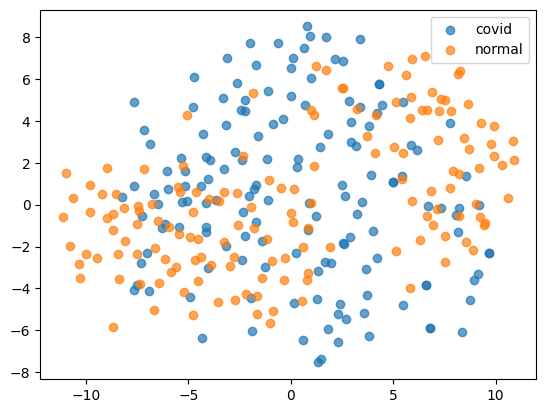

In [ ]:
for i in range(2):
  tf=data_dict['labels']==i
  data=data_dict['data'][tf]
  tsne=TSNE(n_components=2).fit_transform(data.reshape(data.shape[0],-1))
  plt.scatter(tsne[:,0],tsne[:,1],alpha=0.7,label=index_to_label[i])

plt.legend()

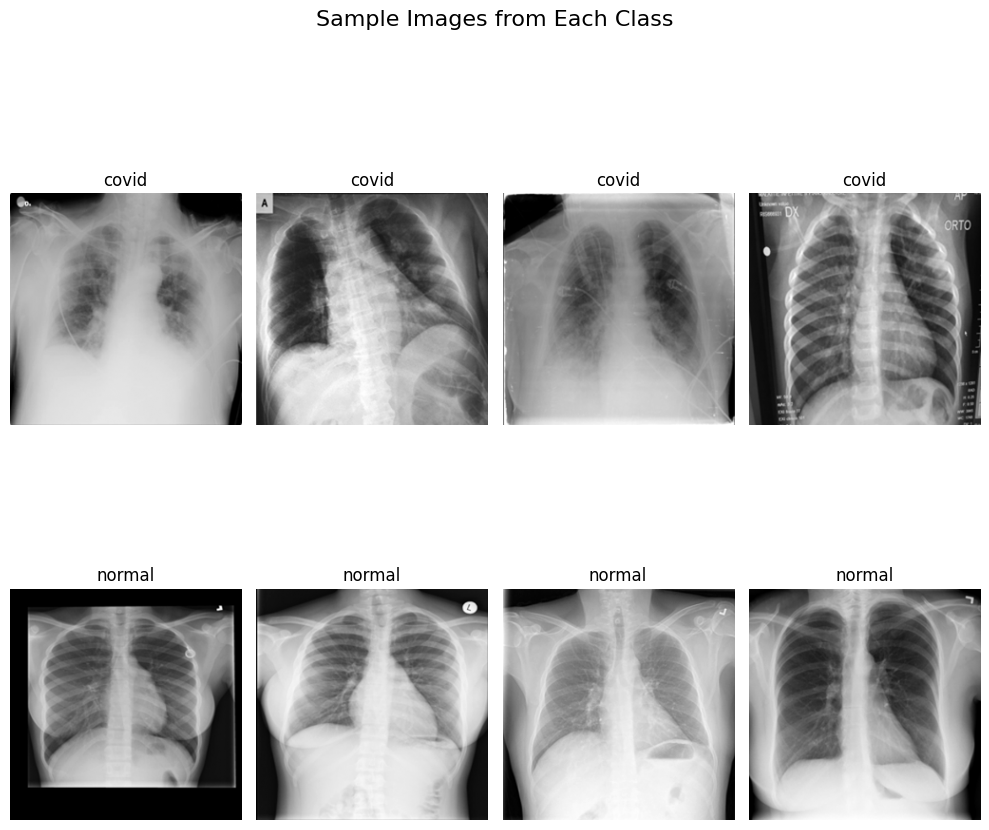

In [ ]:

def show_samples(data_dict, index_to_label):
    fig, axs = plt.subplots(2, 4, figsize=(10, 10))
    fig.suptitle('Sample Images from Each Class', fontsize=16)

    for class_index in range(2):
        tf = data_dict['labels'] == class_index
        images = data_dict['data'][tf][:4]
        for j in range(4):
            ax = axs[class_index, j]
            img = images[j]


            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)

            ax.set_title(index_to_label[class_index])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(data_dict, index_to_label)


This code splits the dataset into training, validation, and test sets. First, it divides the data into 90% training and 10% test. Then, it further splits the test set into validation and test sets (approximately 22% for validation and 78% for testing). The splitting is done randomly, with the same random state for reproducibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_dict['data'], data_dict['labels'], test_size=0.1, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.222, random_state=42,shuffle=True)


The original X_train data must have all data points with the same size and model, meaning they should be in RGB format. A series of transformations should be applied to the data to make it ready for the network and learning in both the transform and augmentations functions. The augmented data (X_train_augmented) is then combined with the original X_train to create a unified dataset.

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((244, 244)),
    transforms.ToTensor()  ])

augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(244),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
])

processed_images = []
for img in X_train:
    img_fixed = transform(img)
    processed_images.append(img_fixed)

X_train_tensor = torch.stack(processed_images)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)



augmented_images = []
augmented_labels = []

for img, label in zip(X_train, y_train):
    augmented_img = augmentations(img)
    augmented_images.append(augmented_img)
    augmented_labels.append(label)

X_train_augmented_tensor = torch.stack(augmented_images)
y_train_augmented_tensor = torch.tensor(augmented_labels, dtype=torch.long)

X_train_combined = torch.cat([X_train_tensor, X_train_augmented_tensor], dim=0)
y_train_combined = torch.cat([y_train_tensor, y_train_augmented_tensor], dim=0)

train_data_combined = TensorDataset(X_train_combined, y_train_combined)
train_loader_combined = DataLoader(train_data_combined, batch_size=32, shuffle=True)


This code processes the validation set (X_val) in the same way as the training set. Each image is passed through the transform function to convert it to RGB, resize it, and convert it into a tensor. The processed validation images are then stored in X_val_tensor and paired with the corresponding labels (y_val_tensor) to create a TensorDataset. This dataset is loaded into a DataLoader for efficient batching during validation.

In [ ]:
processed_images_val = []
for img in X_val:
    img_fixed = transform(img)
    processed_images_val.append(img_fixed)

X_val_tensor = torch.stack(processed_images_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

This code processes the test set (X_test) in the same way as the training and validation sets. Each image is transformed using the transform function to convert it to RGB, resize it to the appropriate size, and convert it into a tensor. The processed test images are stored in X_test_tensor and paired with the corresponding labels (y_test_tensor) to create a TensorDataset. This dataset is then wrapped in a DataLoader to allow for efficient batch processing during testing.

In [ ]:
processed_images_test = []
for img in X_test:
    img_fixed = transform(img)
    processed_images_test.append(img_fixed)

X_test_tensor = torch.stack(processed_images_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

the function for training the entire training dataset and apply it to the model you're providing.

In [ ]:
def train_epoch(model,optim,dataloader,loss_fn,device,n_epochs):
  model.train()
  train_loss=0
  train_acc=0
  loss_list=[]
  acc_list=[]
  for _ in (pbar := trange(n_epochs)):
    for img,label in dataloader:
      img,label=img.to(device),label.to(device)
      logistic=model(img)
      loss=loss_fn(logistic,label)
      loss.backward()
      optim.step()
      optim.zero_grad()
      train_acc += (logistic.argmax(dim=1)== label).sum().item()
      train_loss /= len(dataloader)
      train_acc /= len(dataloader.dataset)
    loss_list.append(train_loss)
    acc_list.append(train_acc)


  return loss_list,acc_list


In [ ]:

def valid(model,dataloader,loss_fn,device):
  model.eval()
  val_acc=0
  val_loss=0
  all_preds = []
  all_labels = []
  with torch.inference_mode():
    for img,label in dataloader:
      img,label=img.to(device),label.to(device)
      logistic=model(img)
      loss=loss_fn(logistic,label)
      val_loss += loss.item()
      val_acc += (logistic.argmax(dim=1) == label).sum().item()

      all_preds.extend(logistic.argmax(dim=1).cpu().numpy())
      all_labels.extend(label.cpu().numpy())
    val_loss/=len(dataloader)
    val_acc /= len(dataloader.dataset)
    return val_loss,val_acc,all_preds,all_labels



In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
optim = Adam(resnet18.parameters(),lr=1e-5)


This code snippet modifies the pre-trained ResNet-18 model by freezing all layers except the final fully connected layer and the last block of layers (layer4), allowing for fine-tuning

In [ ]:
from torchvision import models
from torch import nn
from torch.optim import Adam

model18 = models.resnet18(weights='DEFAULT')
for param in model18.parameters():
    param.requires_grad = False


num_ftrs = model18.fc.in_features
model18.fc = nn.Linear(num_ftrs, 2)
for param in model18.fc.parameters():
    param.requires_grad = True

for param in model18.layer4.parameters():
    param.requires_grad = True

model18 = model18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)

loss_fn=CrossEntropyLoss()

In [ ]:
optim = Adam(model18.parameters(),lr=1e-5)


In [ ]:
loss18_,acc18_=train_epoch(model18,optim,train_loader_combined,loss_fn,device,20)

100%|██████████| 20/20 [31:47<00:00, 95.37s/it] 


In [ ]:
loss18,acc18,pred18,label18=valid(model18,val_loader,loss_fn,device)

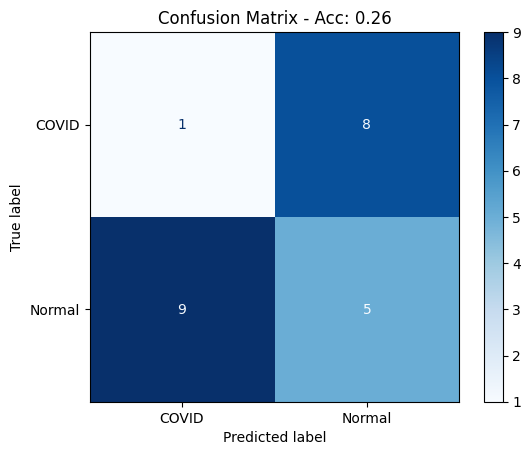

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(label18, pred18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["COVID",'Normal'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Acc: {acc18:.2f}')
plt.show()

The code loads a pre-trained ResNet-50 model, freezes all its layers (prevents updates to their weights during training), and then modifies the final fully connected layer to output 2 classes (for binary classification). The last block (layer4) is unfrozen for fine-tuning.

In [ ]:
model50 = models.resnet50(weights='DEFAULT')
for param in model50.parameters():
    param.requires_grad = False


num_ftrs50 = model50.fc.in_features
model50.fc = nn.Linear(num_ftrs50, 2)
for param in model50.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

model50 = model50.to(device)
if device == 'cuda':
    resnet50 = torch.compile(resnet50)

In [ ]:
loss50,acc50=train_epoch(model50,optim,train_loader_combined,loss_fn,device,20)

100%|██████████| 20/20 [1:16:56<00:00, 230.85s/it]


In [ ]:
loss50_,acc50_,pred50_,label50_=valid(model50,val_loader,loss_fn,device)

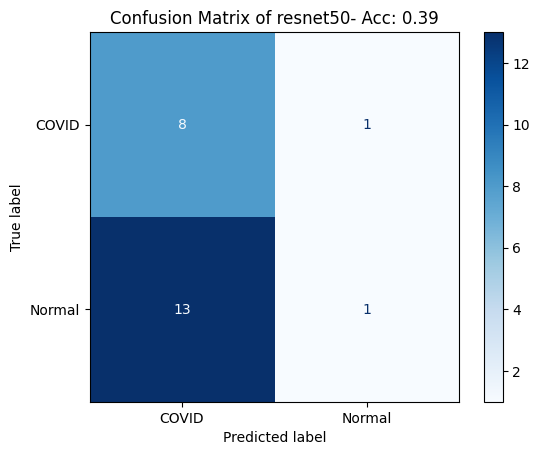

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(label50_, pred50_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["COVID",'Normal'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix of resnet50- Acc: {acc50_:.2f}')
plt.show()

The ResNet-50 model gave better accuracy because it is a more complex model compared to ResNet-18. However, to achieve better accuracy, you need to make more layers learnable or use more complex models.

Due to hardware limitations and lack of stable internet access, the more complex models were only implemented at the code level and could not be fully trained. However, the architecture and configurations required for their complete execution have been carefully designed and implemented.

In [ ]:
model152 = models.resnet152(weights='DEFAULT')
for param in model152.parameters():
    param.requires_grad = False


num_ftrs152 = model152.fc.in_features
model152.fc = nn.Linear(num_ftrs50, 2)
for param in model152.fc.parameters():
    param.requires_grad = True

for param in model152.layer4.parameters():
    param.requires_grad = True

model50 = model152.to(device)
if device == 'cuda':
    resnet152 = torch.compile(resnet152)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 68.9MB/s]


In [ ]:
#loss152,acc152=train_epoch(model152,optim,train_loader_combined,loss_fn,device,20)

In [ ]:
#loss152_,acc152_,pred152_,label152_=valid(model152,val_loader,loss_fn,device)

In [ ]:
model_dens = models.densenet121(pretrained=True)

for param in model_dens.parameters():
    param.requires_grad = False

for param in model_dens.features.denseblock4.parameters():
    param.requires_grad = True

model_dens.classifier = nn.Linear(model_dens.classifier.in_features, 2)

model_dens.classifier = nn.Linear(model_dens.classifier.in_features, 2)


model_dens.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 40.1MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#loss_dens_,acc_dens_=train_epoch(model_dens,optim,train_loader_combined,loss_fn,device,20)

In [ ]:
#loss_dens,acc_dens,pred_dens,label_dens=valid(model152,val_loader,loss_fn,device)

Due to limitations, I only used 2 classes, but you can use more classes.
